# CIS 6800 Project: VAE and Diffusion Transformer

Instructions:

*  In this HW you will implement a patch-based VAE and train a Diffusion model using the pre-trained VAE checkpoint.
*  We provided you with a zipfile that contains a subset of 10,000 images from the CelebA dataset.
*  The Diffusion training session lasts a couple hours, so you should start part (b) as early as you can!
*  **Please submit your ipynb notebook as well as a pdf version of it. Include all visualizations and answers to the questions.**
*   Part A is due Wed 10/28, and Part B is due Wed 11/4.






Diffusion Transformer Paper: [https://arxiv.org/pdf/2212.09748](https://arxiv.org/pdf/2212.09748)


In [31]:
!pip install -q torch torchvision numpy tqdm datasets torch-ema pytorch-lightning timm

In [32]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as tf
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid, save_image
from torch_ema import ExponentialMovingAverage as EMA
import pytorch_lightning as pl

import math
import random
import numpy as np
from tqdm import tqdm
from einops import rearrange, repeat  # You can learn about einops at https://einops.rocks
from itertools import pairwise
from accelerate import Accelerator
from types import SimpleNamespace
from typing import Optional
import matplotlib.pyplot as plt
import torch.optim as optim

import zipfile
import io
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image, make_grid


In [33]:
# Set the seed for reproducibility

def set_seed(seed: int):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

# Part A

# Variational Autoencoder (VAE)


In this part of the project you will train a Patch-based VAE to capture key facial features on on a subset of the CelebA dataset, consisting of 10000 face images. You can use the code below to load images from the given zipfile. We recommend resizing the images to (32, 32) for the following tasks but you're welcome to experiment with different sizes.

In [34]:
class CelebADataset(Dataset):
    def __init__(self, zip_file, transform=None):
        self.zip_file = zip_file
        self.transform = transform

        # Open the zip file and get the list of images
        self.zip = zipfile.ZipFile(self.zip_file, 'r')
        self.image_list = [file for file in self.zip.namelist() if file.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Get image name from the list
        img_name = self.image_list[idx]
        try:
            # Read image data from the zip file
            with self.zip.open(img_name) as img_file:
                img_data = img_file.read()
                img = Image.open(io.BytesIO(img_data)).convert('RGB')

            if self.transform:
                img = self.transform(img)

        except zipfile.BadZipFile:
            # print(f"BadZipFile error encountered with image {img_name}. Skipping this file.")
            return None

        return img

def collate_fn(batch):
    # Filter out None values (e.g., images that couldn't be loaded)
    batch = [b for b in batch if b is not None]
    # If the batch is empty after filtering, return None (can be skipped by DataLoader)
    if len(batch) == 0:
        return None

    return torch.utils.data.dataloader.default_collate(batch)

# Usage of the dataset and dataloader
def get_celeba_dataloader(zip_path, batch_size=32, image_size=(32, 32)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    dataset = CelebADataset(zip_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

    return dataloader

# Function to display original and reconstructed images (4 images only)
def show_original_reconstructed(orig_images, recon_images, epoch):
    # Move the images back to CPU and denormalize
    orig_images = orig_images.cpu().numpy()
    recon_images = recon_images.cpu().numpy()

    # Clip the values to the valid range [0, 1] for display
    orig_images = np.clip(orig_images * 0.5 + 0.5, 0, 1)  # Denormalize and clip
    recon_images = np.clip(recon_images * 0.5 + 0.5, 0, 1)  # Denormalize and clip

    # Plot images side by side (4 images)
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))
    for i in range(4):
        # Original image
        axes[0, i].imshow(orig_images[i].transpose(1, 2, 0))  # Correct shape for imshow
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        # Reconstructed image
        axes[1, i].imshow(recon_images[i].transpose(1, 2, 0))  # Correct shape for imshow
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.suptitle(f'Epoch {epoch}: Original vs Reconstructed')
    plt.show()

In [35]:
#Initialize your dataloaders here
zip_file_path = "celeba_10000_images.zip"
dataloader = get_celeba_dataloader(zip_file_path, batch_size=128, image_size=(32, 32))

### Patch-based Variational Autoencoder

PatchVAE divides an input image into smaller patches and operates on these patches rather than the entire image at once. By processing images in patches, the PatchVAE learns to capture fine-grained (local) and high-level (global) patterns, depending on the patch size. In this section you should:

1.   Implement the PatchEmbed Class. This class is designed to create overlapping patches from an image, embed those patches into a latent space, and provide a method to reconstruct the image from the latent representations.

2.   Implement the PatchVAE model.

    *   The `encode` method convert patch embeddings into latent variables (mu and logvar) through a convolutional encoder. Rearrange patches to treat them as channels before passing them through the encoder.
    *   The `reparameterize` method applied the reparameterization trick `z = mu + eps * std` where `eps` is sampled from a standard normal distribution.
    *  The `decode` method convert the latent variable z back into patch embeddings, then reconstruct the original image from these patches
    *  The `forward` method first patchifies the image, encode, reparameterize, decode, and finally reconstruct the image
    *  The `compute_loss` calculates the reconstruction loss (Mean Squared Error) and the KL divergence loss to encourage the latent space to follow a normal distribution. Combine these losses to get the total VAE loss.
    *  The `sample` method generates new random images from the learned latent space. Random latent vector `z` are sampled, decoded into patches, and reconstructed into full images.


3.   Train the model on the faces dataset. **Experiment with different patch sizes and report the patch size with the best tradeoff between low-level details and high-level texture. Plot the training and validation loss and visualize a couple reconstructed images during training.**

4. After training, generate sample images from the latent space. Specifically, you need to sample latent vectors from a normal distribution, decode the latent varaibles, and reconstruct the images. **Visualize 4 generated examples. Do the generated images resemble realistic human faces? Explain in a couple sentences.**

In [25]:
class PatchEmbed(nn.Module):
    # This class is designed to create overlapping patches from an image, embed those
    # patches into a latent space, and provide a method to reconstruct the image from the latent representations.
    def __init__(self, img_size=128, patch_size=32, stride=8, channels=3, embed_dim=128, bias=True):
        super().__init__()
        """
        Use Conv2D to create image patches of size (patch_size, patch_size) with overlapping regions.

        Each patch should have embedding size embed_dim.
        """
        self.patch_size = patch_size
        self.stride = stride
        self.embed_dim = embed_dim
        self.img_size = img_size

        # Conv2d to generate overlapping patches (from image to latent space)
        self.proj = nn.Conv2d(channels, embed_dim, kernel_size=patch_size, stride=stride, bias=bias)

        # Transposed Conv2d to reconstruct patches from latent space to RGB (from latent to image space)
        self.deconv = nn.ConvTranspose2d(embed_dim, 3, kernel_size=patch_size, stride=stride, bias=bias)

        H_out = (img_size - self.patch_size) // self.stride + 1
        W_out = (img_size - self.patch_size) // self.stride + 1
        self.num_patches = H_out * W_out

    def forward(self, x):
        """
        Input x is an image of size [B, C, img_size, img_size]

        Return patches of size [B, num_patches, embed_dim]
        """
        ######## BEGIN TODO ########
        patches = self.proj(x)
        patches = patches.reshape(x.size(0), self.num_patches, self.embed_dim)
        ######## END TODO ########

        return patches

    def reconstruct(self, patches, img_size):
        """
        Reconstruct the image from the patches by averaging overlapping regions.
        Input patches: [B, num_patches, embed_dim]
        img_size: (img_size, img_size)  # original size of the input image

        Output images: [B, C, img_size, img_size]
        """
        ######## BEGIN TODO ########
        # reshape patches to [B, embed_dim, sqrt(num_patches), sqrt(num_patches)]
        patches = patches.reshape(patches.size(0), self.embed_dim, int(math.sqrt(self.num_patches)), int(math.sqrt(self.num_patches)))
        reconstructed_image = self.deconv(patches)
        ######## END TODO ########

        return reconstructed_image

In [42]:
class PatchVAE(nn.Module):
    def __init__(self, patch_size, img_channels, img_size,
                  embed_dim=1024, latent_dim=512, stride=8):
        super(PatchVAE, self).__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Patch embedding layer (Patchify the image)
        self.patch_embed = PatchEmbed(patch_size=patch_size, stride=stride, channels=img_channels, embed_dim=embed_dim, img_size=img_size)
        self.num_patches = self.patch_embed.num_patches

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(embed_dim, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.conv_mu = nn.Conv2d(128, latent_dim, kernel_size=3, stride=1, padding=1)
        self.conv_logvar = nn.Conv2d(128, latent_dim, kernel_size=3, stride=1, padding=1)

        # Decoder
        self.decoder_input = nn.Conv2d(latent_dim, 128, kernel_size=3, stride=1, padding=1)
        self.decoder = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, embed_dim, kernel_size=3, stride=1, padding=1),
        )

    def encode(self, patches):
        """
        Encode the patch embeddings into latent space (mu and logvar).
        Args:
            patches: Patch embeddings of shape [B, num_patches, embed_dim].
        """
        # convert patch embeddings into latent variables (mu and logvar) through a convolutional
        #  encoder. Rearrange patches to treat them as channels before passing them through the encoder.
        ######## BEGIN TODO ########
        patches = rearrange(patches, 'b p c -> b c 1 p')
        patches = self.encoder(patches)
        mu = self.conv_mu(patches)
        logvar = self.conv_logvar(patches)
        ######## END TODO ########
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) using N(0,1).
        Args:
            mu: Mean of the latent distribution.
            logvar: Log variance of the latent distribution.
        """
        # applied the reparameterization trick `z = mu + eps * std`
        #  where `eps` is sampled from a standard normal distribution.
        ######## BEGIN TODO ########
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        ######## END TODO ########
        return mu + eps * std

    def decode(self, z):
        """
        Decode the latent variable z back to patch embeddings.
        Args:
            z: Latent variable of shape [B, latent_dim, 1, num_patches].
        """
        ######## BEGIN TODO ########
        # convert the latent variable z back into patch embeddings, then econstruct the original image from these patches
        input = self.decoder_input(z)
        patch_recon = self.decoder(input)
        ######## END TODO ########
        return rearrange(patch_recon, 'b c 1 p -> b p c')  # Back to (B, num_patches, embed_dim)

    def forward(self, x):
        """
        Forward pass through the VAE. Patchify the input, encode into latent space, reparameterize, and decode.
        Args:
            x: Input image of shape [B, C, img_size, img_size].
        """
        # method first patchifies the image, encode, reparameterize, decode, and finally reconstruct the image
        ######## BEGIN TODO ########
        patches = self.patch_embed(x)
        mu, logvar = self.encode(patches) #encode
        z = self.reparameterize(mu, logvar) #reparameterize
        decoded_patch = self.decode(z) #decode
        recon_image = self.patch_embed.reconstruct(decoded_patch, self.img_size) #reconstruct
        ######## END TODO ########

        return recon_image, mu, logvar

    def compute_loss(self, recon_image, original_image, mu, logvar):
        """
        Compute the VAE loss, which consists of the reconstruction loss and KL divergence.
        Args:
            recon_image: Reconstructed image.
            original_image: Original input image.
            mu: Mean of the latent distribution.
            logvar: Log variance of the latent distribution.
        Returns:
            loss (Tensor): Total loss (reconstruction loss + KL divergence).
        """
        ######## BEGIN TODO ########
        # calculates the reconstruction loss (Mean Squared Error) and the KL divergence loss to encourage the latent space to
        # follow a normal distribution. Combine these losses to get the total VAE loss.
        mean_squared_l = nn.MSELoss(reduction='sum')
        recon_loss = mean_squared_l(recon_image, original_image)
        recon_loss /= original_image.size(0)
        kl_loss = -0.5 * torch.sum(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar))
        kl_loss /= original_image.size(0)
        ######## END TODO ########
        return recon_loss, kl_loss

    def sample(self, num_samples):
        """
        Generate random samples from the learned distribution.
        Args:
            num_samples (int): Number of samples to generate.
        Returns:
            samples (Tensor): Generated
        """
        # generates new random images from the learned latent space. Random latent vector `z`
        # are sampled, decoded into patches, and reconstructed into full images.
        ######## BEGIN TODO ########
        # random laten vector z
        z = torch.randn(num_samples, self.latent_dim, 1, self.num_patches).to(self.device)
        decoded_patch = self.decode(z) # decode
        sample_images = self.patch_embed.reconstruct(decoded_patch, self.img_size).detach()
        ######## END TODO ########
        return sample_images

In [37]:
def train_patchvae(model, dataloader, optimizer, device, epochs=10, print_interval=100, checkpoint_path='best_model.pth'):
    """
    Training loop for the PatchVAE model with visualization of reconstructed images and saving the best model checkpoint.

    Args:
        model: The PatchVAE model to be trained.
        dataloader: Dataloader for the training data.
        optimizer: Optimizer for updating the model parameters.
        device: Device (CPU or GPU) on which the training will run.
        epochs: Number of training epochs.
        print_interval: Interval at which the loss will be printed during training.
        checkpoint_path: Path to save the best model checkpoint.

    Returns:
        losses: List of training losses for each epoch.
    """
    model.train()
    model.to(device)
    losses = []
    best_loss = float('inf')  # Initialize with a large value
    initial_beta = 0.0005  # Start with a small KL weight
    final_beta = 1.0    # Gradually increase to full KL weight

    from datetime import datetime
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter(f'logs/patch_vae_{timestamp}')

    for epoch in range(epochs):
        ######## BEGIN TODO ########
        model.train(True)
        running_loss = 0.0
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), position=0, leave=True, desc=f'Epoch: {epoch}/{epochs}')
        beta = min(final_beta, initial_beta + (epoch * ((final_beta - initial_beta) / epochs)))

        for i, data in progress_bar:
            img = data.to(device)
            optimizer.zero_grad()
            recon_img, mu, logvar = model(img)
            recon_loss, kl_loss = model.compute_loss(recon_img, img, mu, logvar)
            loss = recon_loss + beta*kl_loss
            loss.backward() # not sure
            optimizer.step()
            running_loss += loss.item()
            progress_bar.set_postfix(
                {
                    "loss": f"{loss:.3f}",
                    "kl_loss": f"{kl_loss:.3f}",
                    "recon_loss": f"{recon_loss:.3f}",
                    "variance": f"{logvar.exp().mean().item():.3f}",
                }
            )
            writer.add_scalar('Train_Loss/step', loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar('KL_Loss/step', kl_loss.item(), epoch * len(dataloader) + i)
            writer.add_scalar('Recon_Loss/step', recon_loss.item(), epoch * len(dataloader) + i)

        avg_loss = running_loss / len(dataloader)
        losses.append(avg_loss)
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), checkpoint_path)

        model.eval()
        with torch.no_grad():
            rand_indexs = torch.randint(0, len(dataloader), (4,))
            test_images = next(iter(dataloader))[rand_indexs]
            test_images = test_images.to(device)
            recon_images = []
            val_losses = []
            val_recon_losses = []
            val_kl_losses = []
            val_variances = []
            
            for img in test_images:
                recon_img, mu, logvar = model(img.unsqueeze(0))
                recon_images.append(recon_img)
                recon_loss, kl_loss = model.compute_loss(recon_img, img.unsqueeze(0), mu, logvar)
                val_losses.append(float(recon_loss + beta*kl_loss))
                val_recon_losses.append(float(recon_loss))
                val_kl_losses.append(float(kl_loss))
                val_variances.append(float(logvar.exp().mean().item()))
                
            recon_images = torch.cat(recon_images, dim=0)
            val_loss = np.mean(val_losses)
            val_recon_loss = np.mean(val_recon_losses)
            val_kl_loss = np.mean(val_kl_losses)
            val_variance = np.mean(val_variances)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {val_loss:.3f}, Recon Loss: {val_recon_loss:.3f}, KL Loss: {val_kl_loss:.3f}, Variance: {val_variance:.3f}")
            writer.add_scalars("Training vs Validation Loss", {"Train": avg_loss, "Validation": val_loss}, epoch)
            visualize_reconstruction(test_images, recon_images, epoch)
        
        writer.flush() # Write to disk

    ######## END TODO ########
    return losses

def visualize_reconstruction(original_images, recon_images, epoch):
    """
    Visualize original and reconstructed images side by side.

    Args:
        original_images: Batch of original images (values between 0 and 1).
        recon_images: Batch of reconstructed images (values between 0 and 1).
        epoch: Current epoch number.
    """
    num_images = min(4, original_images.size(0))  # Visualize at most 4 images
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))

    for i in range(num_images):
        # Original images (ensure values are between 0 and 1)
        orig_img = original_images[i].permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
        orig_img = np.clip(orig_img, 0, 1)  # Clip values to [0, 1] range

        # Reconstructed images (ensure values are between 0 and 1)
        recon_img = recon_images[i].permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
        recon_img = np.clip(recon_img, 0, 1)  # Clip values to [0, 1] range

        # Display original images
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Display reconstructed images
        axes[1, i].imshow(recon_img)
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
    plt.show()

Device: cuda


Epoch: 0/15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0/15: 100%|██████████| 79/79 [00:07<00:00, 10.19it/s, loss=685.532, kl_loss=493.393, recon_loss=685.285, variance=0.544]  


Epoch 1/15, Loss: 506.820, Recon Loss: 506.683, KL Loss: 275.969, Variance: 0.651


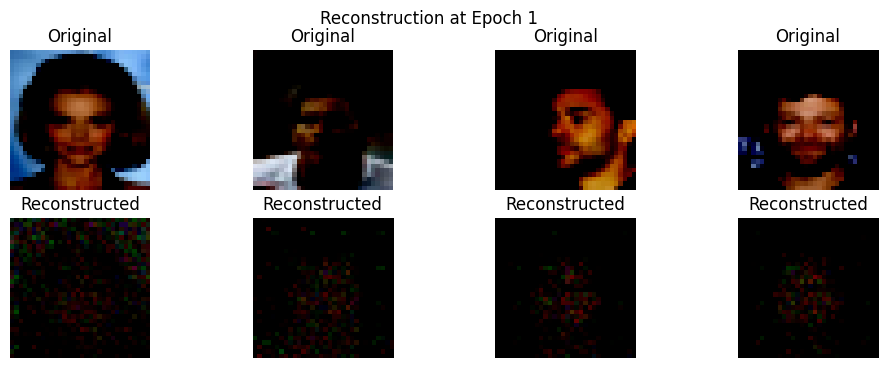

Epoch: 1/15: 100%|██████████| 79/79 [00:07<00:00, 10.33it/s, loss=426.992, kl_loss=402.676, recon_loss=399.959, variance=0.589]


Epoch 2/15, Loss: 441.735, Recon Loss: 417.357, KL Loss: 363.129, Variance: 0.596


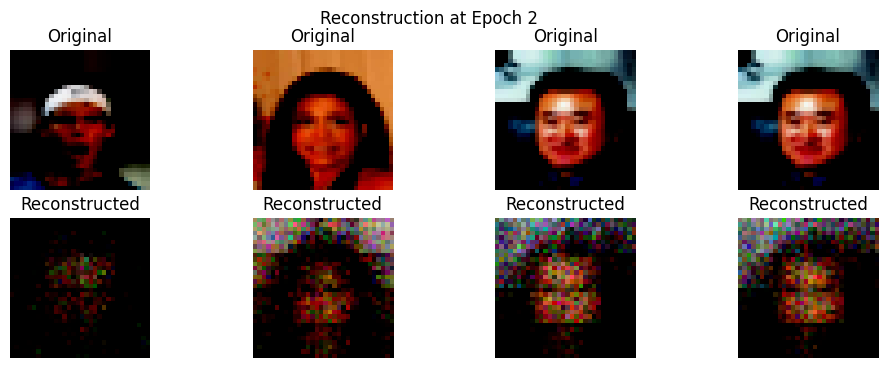

Epoch: 2/15: 100%|██████████| 79/79 [00:07<00:00, 10.41it/s, loss=365.248, kl_loss=304.010, recon_loss=324.581, variance=0.722]


Epoch 3/15, Loss: 288.588, Recon Loss: 250.406, KL Loss: 285.437, Variance: 0.733


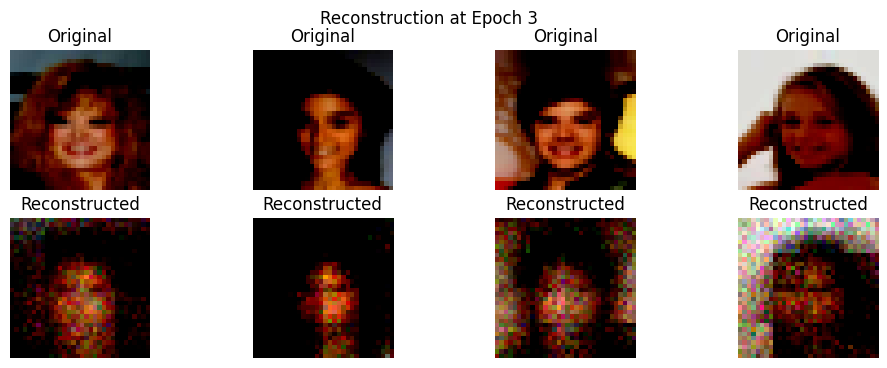

Epoch: 3/15: 100%|██████████| 79/79 [00:07<00:00, 10.11it/s, loss=342.951, kl_loss=260.457, recon_loss=290.755, variance=0.779]


Epoch 4/15, Loss: 351.017, Recon Loss: 298.589, KL Loss: 261.616, Variance: 0.779


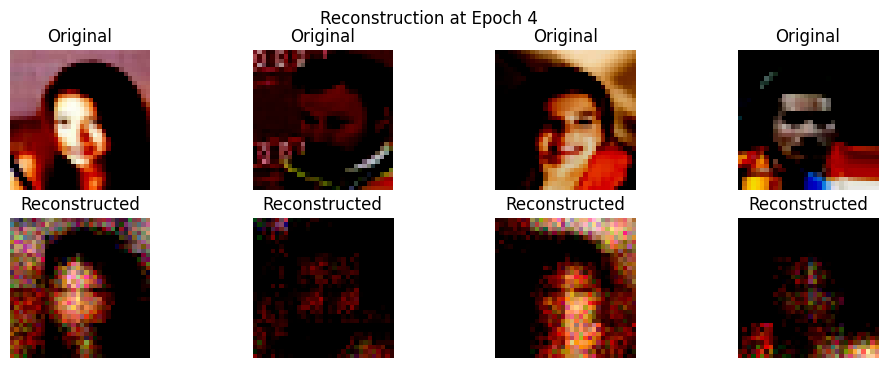

Epoch: 4/15: 100%|██████████| 79/79 [00:07<00:00, 10.33it/s, loss=339.939, kl_loss=222.378, recon_loss=280.557, variance=0.815]


Epoch 5/15, Loss: 268.854, Recon Loss: 218.592, KL Loss: 188.222, Variance: 0.818


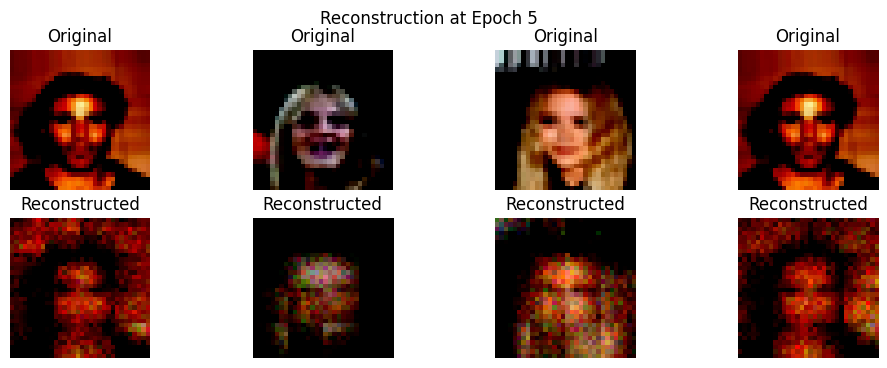

Epoch: 5/15: 100%|██████████| 79/79 [00:07<00:00, 10.53it/s, loss=294.562, kl_loss=190.526, recon_loss=230.990, variance=0.836]


Epoch 6/15, Loss: 292.589, Recon Loss: 228.448, KL Loss: 192.232, Variance: 0.838


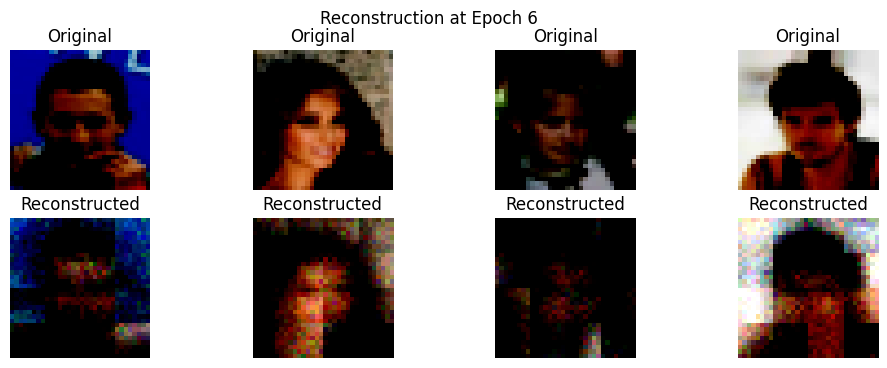

Epoch: 6/15: 100%|██████████| 79/79 [00:07<00:00, 10.41it/s, loss=323.315, kl_loss=175.047, recon_loss=253.244, variance=0.853]


Epoch 7/15, Loss: 310.564, Recon Loss: 234.036, KL Loss: 191.177, Variance: 0.853


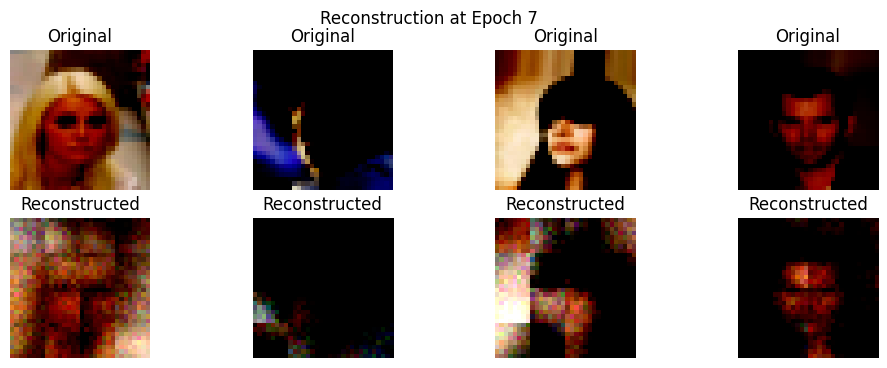

Epoch: 7/15: 100%|██████████| 79/79 [00:07<00:00, 10.15it/s, loss=304.234, kl_loss=157.005, recon_loss=230.923, variance=0.865]


Epoch 8/15, Loss: 266.701, Recon Loss: 199.917, KL Loss: 143.026, Variance: 0.869


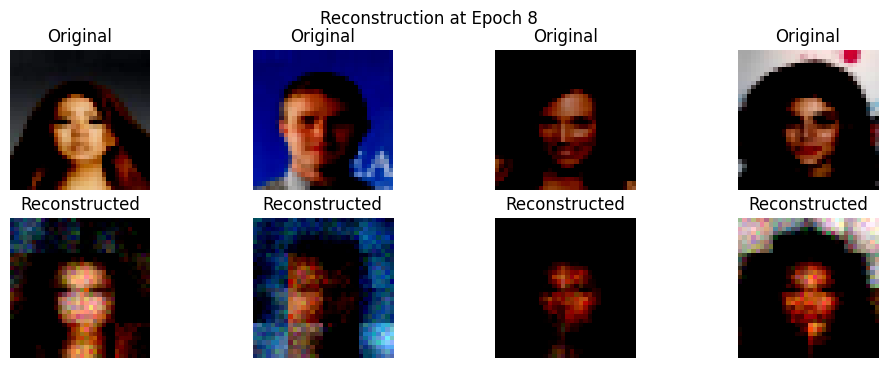

Epoch: 8/15: 100%|██████████| 79/79 [00:07<00:00, 10.39it/s, loss=337.797, kl_loss=148.005, recon_loss=258.826, variance=0.874]


Epoch 9/15, Loss: 299.959, Recon Loss: 227.285, KL Loss: 136.204, Variance: 0.873


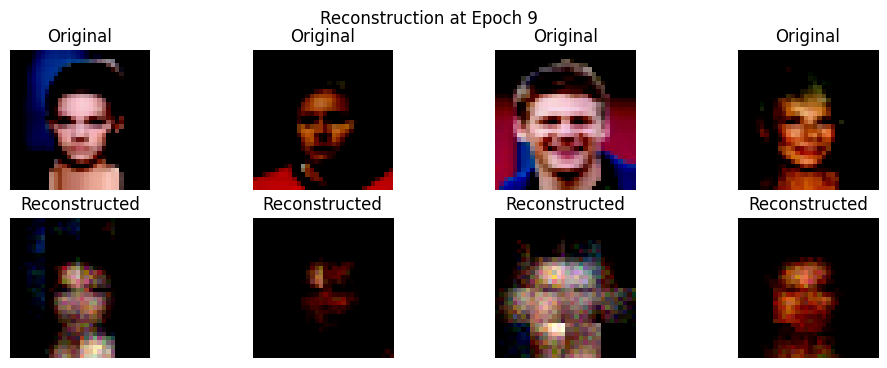

Epoch: 9/15: 100%|██████████| 79/79 [00:07<00:00, 10.33it/s, loss=313.597, kl_loss=134.716, recon_loss=232.740, variance=0.885]


Epoch 10/15, Loss: 318.424, Recon Loss: 226.875, KL Loss: 152.532, Variance: 0.878


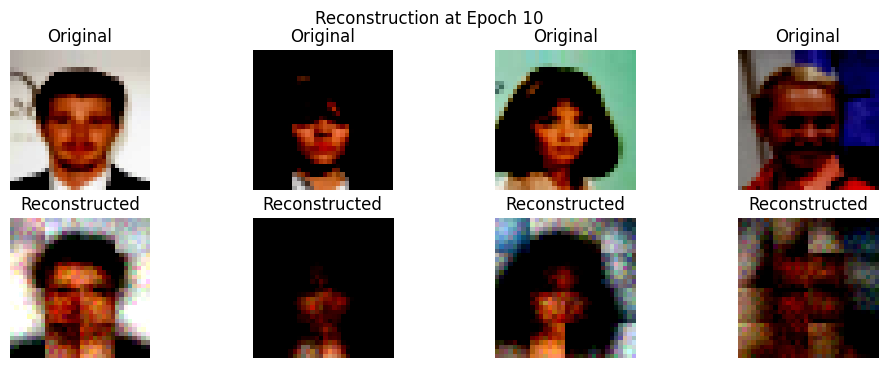

Epoch: 10/15: 100%|██████████| 79/79 [00:07<00:00,  9.92it/s, loss=315.173, kl_loss=121.750, recon_loss=233.986, variance=0.895]


Epoch 11/15, Loss: 296.706, Recon Loss: 214.049, KL Loss: 123.955, Variance: 0.894


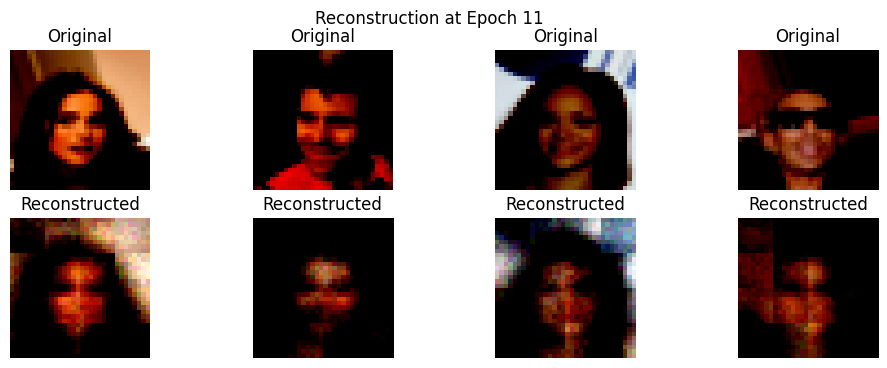

Epoch: 11/15: 100%|██████████| 79/79 [00:07<00:00,  9.88it/s, loss=334.410, kl_loss=110.140, recon_loss=253.626, variance=0.904]


Epoch 12/15, Loss: 325.776, Recon Loss: 227.596, KL Loss: 133.858, Variance: 0.900


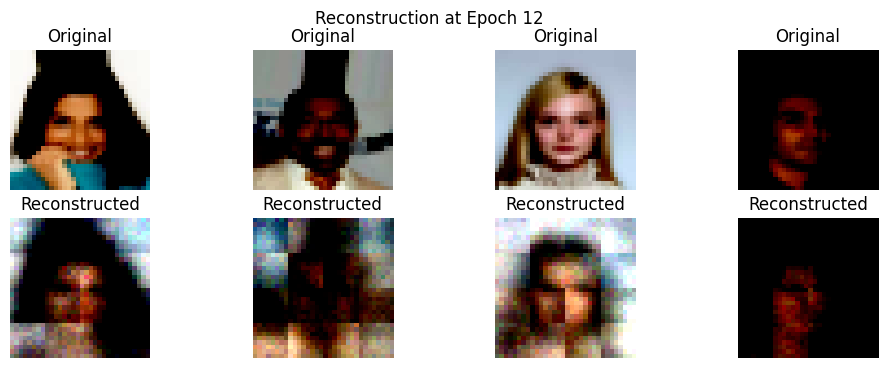

Epoch: 12/15: 100%|██████████| 79/79 [00:08<00:00,  9.71it/s, loss=346.936, kl_loss=112.407, recon_loss=256.998, variance=0.911]


Epoch 13/15, Loss: 305.094, Recon Loss: 222.805, KL Loss: 102.849, Variance: 0.910


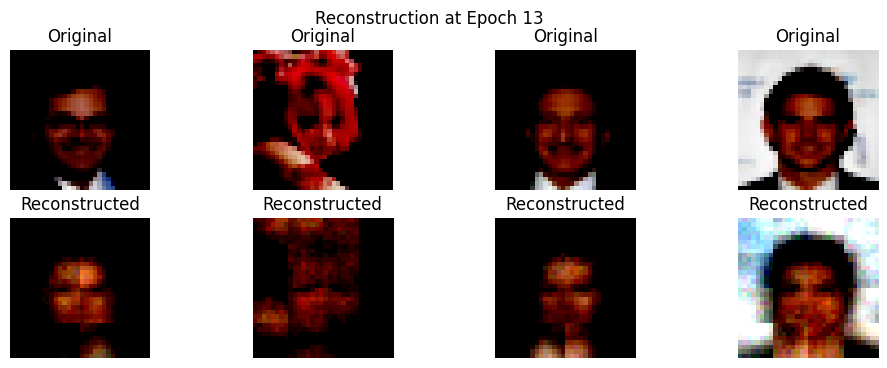

Epoch: 13/15: 100%|██████████| 79/79 [00:09<00:00,  8.38it/s, loss=336.776, kl_loss=105.567, recon_loss=245.278, variance=0.918]


Epoch 14/15, Loss: 363.864, Recon Loss: 264.849, KL Loss: 114.240, Variance: 0.918


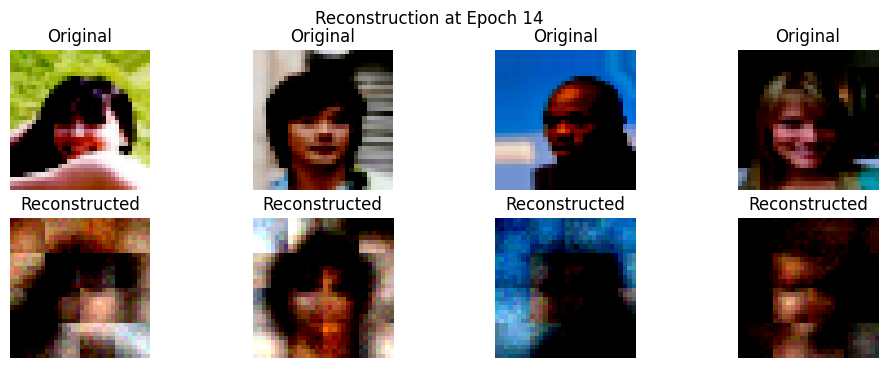

Epoch: 14/15: 100%|██████████| 79/79 [00:09<00:00,  8.16it/s, loss=303.464, kl_loss=86.357, recon_loss=222.861, variance=0.924] 


Epoch 15/15, Loss: 343.337, Recon Loss: 246.976, KL Loss: 103.241, Variance: 0.922


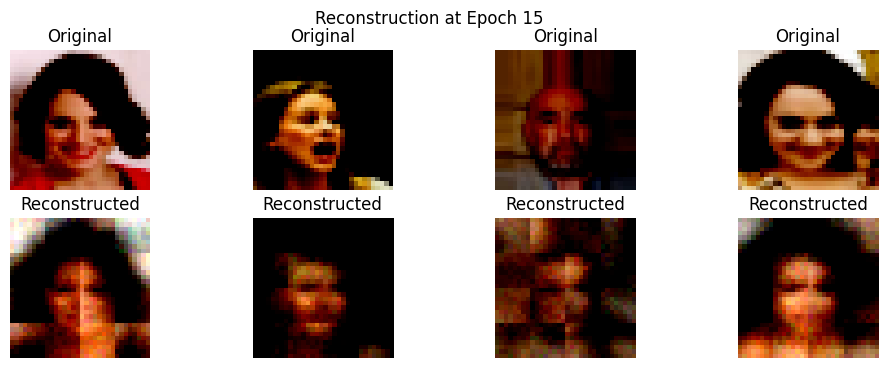

[833.0357519222212,
 514.7764019543612,
 392.07561290113233,
 338.93233403073083,
 316.8494413351711,
 306.98686005797566,
 304.75627387324465,
 304.8212635668018,
 307.3976996699466,
 309.1994567098497,
 311.9210869511472,
 314.06029500840583,
 315.2129682709899,
 315.6122312907931,
 315.5359647726711]

In [38]:
# Train PatchVAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
resume_training = False
checkpoint_path = 'best_vae_model.pth'


vae = PatchVAE(patch_size=8, img_channels=3, img_size=32, embed_dim=64, latent_dim=128).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

if resume_training:
    vae.load_state_dict(torch.load(checkpoint_path))

train_patchvae(vae, dataloader, optimizer, device, epochs=15, checkpoint_path='best_vae_model.pth')

samples min: -0.8046179
samples max: 0.5596795


C:\Users\Sam\AppData\Local\Temp\ipykernel_8416\264720526.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(checkpoint_path))


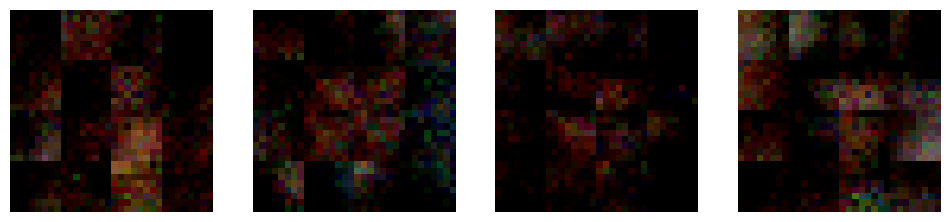

In [50]:
# Generate images by sampling from latent space
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = 'best_vae_model.pth'
vae = PatchVAE(patch_size=8, img_channels=3, img_size=32, embed_dim=64, latent_dim=128).to(device)
vae.load_state_dict(torch.load(checkpoint_path))
vae.eval()

samples = vae.sample(4)
samples = samples.permute(0, 2, 3, 1).cpu().numpy()
print("samples min:", np.min(samples))
print("samples max:", np.max(samples))

samples = np.clip(samples, 0, 1)
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(samples[i])
    axes[i].axis('off')

# Part B

# Diffusion Transformer (DiT)


We will train a DiT that operates in the patch latent space on the same dataset. The input image is decomposed into patches and processed by several DiT blocks.

### Implement Noise Scheduler


You will implement parts of the [DDPM scheduler](https://huggingface.co/docs/diffusers/en/api/schedulers/ddpm) using the following steps.

1. Define $\beta$ as a tensor of $N$ linearly spaced values between $\beta_{start}$ and $\beta_{end}$.

$$\beta = \left[\beta_{\text{start}}, \beta_{\text{start}} + \frac{\beta_{\text{end}} - \beta_{\text{start}}}{N - 1}, \ldots, \beta_{\text{end}}\right]$$

2. Calculate $\sigma$ using the cumulative product of $1 - \beta$.

$$\sigma = \sqrt{\frac{1}{\prod_{i=0}^{N-1}(1 - \beta_i)} - 1}$$

In [ ]:
class DDPMScheduler:
    def __init__(self, N: int=1000, beta_start: float=0.0001, beta_end: float=0.02):
        ######## BEGIN TODO ########
        # self.sigmas = pass
        ######## END TODO ########

    def __getitem__(self, i) -> torch.FloatTensor:
        return self.sigmas[i]

    def __len__(self) -> int:
        return len(self.sigmas)

    def sample_sigmas(self, steps: int) -> torch.FloatTensor:
        indices = list((len(self) * (1 - np.arange(0, steps)/steps)).round().astype(np.int64) - 1)
        return self[indices + [0]]

    def sample_batch(self, x0: torch.FloatTensor) -> torch.FloatTensor:
        batchsize = x0.shape[0]
        return self[torch.randint(len(self), (batchsize,))].to(x0)

### Implement DiT Block

You will implement the DiT Block with adaLN-Zero, as illustrated in Figure 3 of the Diffusion Transformer paper. Specifically, you will need to implement Multi-Head Self-Attention, Modulation, and Adaptive Layer Norm for the DiT Block, and we will provide you with the code structure.

In [ ]:
class Attention(nn.Module):
    def __init__(self, head_dim, num_heads=8, qkv_bias=False):
        super().__init__()
        """
        Inputs:
            head_dim (int): Dimensionality of each attention head
            num_heads (int): Number of attention heads
            qkv_bias (bool): Whether to include bias in the QKV layer
        """
        self.num_heads = num_heads
        self.head_dim = head_dim

        ######## BEGIN TODO ########
        # self.qkv = pass
        # self.proj = pass
        ######## END TODO #######


    def forward(self, x):
        """
        Inputs:
            x (Tensor): Input tensor of shape (B, N, D), where:
                - B: Batch size
                - N: Number of tokens
                - D: Dimensionality (D = num_heads * head_dim)

        Returns:
            Output tensor of shape (B, N, D) after applying attention and projection

        You may use F.scaled_dot_product_attention
        """
        # (B, N, D) -> (B, N, D)
        # N = H * W / patch_size**2, D = num_heads * head_dim

        ######## BEGIN TODO ########
        pass
        ######## END TODO #######

In [ ]:
class Modulation(nn.Module):
    def __init__(self, dim, n):
        super().__init__()
        """
        1. self.proj is constructed as a sequence of operations:
            - A SiLU (Sigmoid-Weighted Linear Unit) activation is applied to the input
            - A linear layer transforms the input from dim to n * dim
        2. The last layer's weights and biases are initialized to zero
        """
        ######## BEGIN TODO ########
        # self.proj = pass
        ######## END TODO #######


    def forward(self, y):
        """
        1. self.proj(y) applies the defined projection, resulting in n * dim
        2. Split the output tensor into n equal parts along dimension 1
        3. Each chunk `m` has the shape dim and represents a separate modulation component
        4. m.unsqueeze(1) adds a new dimension at index 1, necessary for future computations
        """
        ######## BEGIN TODO ########
        pass
        ######## END TODO #######


class AdaptiveLayerNorm(nn.LayerNorm):
    def __init__(self, dim, **kwargs):
        super().__init__(dim, **kwargs)
        """
        Initialize an instance of Modulation with dim and n = 2
        """
        ######## BEGIN TODO ########
        # self.modulation = pass
        ######## END TODO #######


    def forward(self, x, y):
        """
        1. Obtain (scale, shift) tensors from applying modulation on input y
        2. Apply LayerNorm on input x, which we will denote as LayerNorm(x)
        3. Compute AdaptiveLayerNorm as `LayerNorm(x) * (1 + scale) + shift`
        """
        ######## BEGIN TODO ########
        pass
        ######## END TODO #######

In [ ]:
class DiTBlock(nn.Module):
    def __init__(self, head_dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        dim = head_dim * num_heads
        mlp_hidden_dim = int(dim * mlp_ratio)

        self.norm1 = AdaptiveLayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(head_dim, num_heads=num_heads, qkv_bias=True)
        self.norm2 = AdaptiveLayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim, bias=True),
            nn.GELU(approximate="tanh"),
            nn.Linear(mlp_hidden_dim, dim, bias=True),
        )
        self.scale_modulation = Modulation(dim, 2)

    def forward(self, x, y):
        # (B, N, D), (B, D) -> (B, N, D)
        # N = H * W / patch_size**2, D = num_heads * head_dim
        gate_msa, gate_mlp = self.scale_modulation(y)
        x = x + gate_msa * self.attn(self.norm1(x, y))
        x = x + gate_mlp * self.mlp(self.norm2(x, y))
        return x

In [ ]:
def sigma_log_scale(batches, sigma, scaling_factor):
    if sigma.shape == torch.Size([]):
        sigma = sigma.unsqueeze(0).repeat(batches)
    else:
        assert sigma.shape == (batches,), 'sigma.shape == [] or [batches]!'
    return torch.log(sigma)*scaling_factor


def get_sigma_embeds(batches, sigma, scaling_factor=0.5):
    s = sigma_log_scale(batches, sigma, scaling_factor).unsqueeze(1)
    return torch.cat([torch.sin(s), torch.cos(s)], dim=1)


class SigmaEmbedderSinCos(nn.Module):
    def __init__(self, hidden_size, scaling_factor=0.5):
        super().__init__()
        ######## BEGIN TODO ########
        pass
        ######## END TODO #######


    def forward(self, batches, sigma):
        """

        """
        ######## BEGIN TODO ########
        pass
        ######## END TODO #######

### Helper Functions

We provide you with the following helper functions for training DiT. No implementation needed.

In [ ]:
def get_pos_embed(in_dim, patch_size, dim, N=10000):
    n = in_dim // patch_size                                          # Number of patches per side
    assert dim % 4 == 0, 'Embedding dimension must be multiple of 4!'
    omega = 1/N**np.linspace(0, 1, dim // 4, endpoint=False)          # [dim/4]
    freqs = np.outer(np.arange(n), omega)                             # [n, dim/4]
    embeds = repeat(np.stack([np.sin(freqs), np.cos(freqs)]),
                       ' b n d -> b n k d', k=n)                      # [2, n, n, dim/4]
    embeds_2d = np.concatenate([
        rearrange(embeds, 'b n k d -> (k n) (b d)'),                  # [n*n, dim/2]
        rearrange(embeds, 'b n k d -> (n k) (b d)'),                  # [n*n, dim/2]
    ], axis=1)                                                        # [n*n, dim]
    return nn.Parameter(torch.tensor(embeds_2d).float().unsqueeze(0), # [1, n*n, dim]
                        requires_grad=False)

In [ ]:
class ModelMixin:
    def rand_input(self, batchsize):
        assert hasattr(self, 'input_dims'), 'Model must have "input_dims" attribute!'
        return torch.randn((batchsize,) + self.input_dims)

    # Currently predicts eps, override following methods to predict, for example, x0
    def get_loss(self, x0, sigma, eps):
        return nn.MSELoss()(eps, self(x0 + sigma * eps, sigma))

    def predict_eps(self, x, sigma):
        return self(x, sigma)

### Implement Entire DiT Model

In [ ]:
class DiT(nn.Module, ModelMixin):
    def __init__(self, in_dim=32, channels=3, patch_size=2, depth=12,
                 head_dim=64, num_heads=6, mlp_ratio=4.0, sig_embed_factor=0.5,
                 sig_embed_class=None):
        super().__init__()

        self.in_dim = in_dim
        self.channels = channels
        self.patch_size = patch_size
        self.input_dims = (channels, in_dim, in_dim)

        dim = head_dim * num_heads

        self.pos_embed = get_pos_embed(in_dim, patch_size, dim)
        self.x_embed = PatchEmbed(img_size=in_dim, patch_size=patch_size, stride=patch_size,
                                      channels=channels, embed_dim=dim, bias=True)
        self.sig_embed = (sig_embed_class or SigmaEmbedderSinCos)(
            dim, scaling_factor=sig_embed_factor
        )

        self.blocks = nn.ModuleList([
            DiTBlock(head_dim, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])

        self.final_norm = AdaptiveLayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.final_linear = nn.Linear(dim, patch_size**2 * channels)
        self.init()


    def init(self):
        # Initialize transformer layers
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize sigma embedding MLP
        nn.init.normal_(self.sig_embed.mlp[0].weight, std=0.02)
        nn.init.normal_(self.sig_embed.mlp[2].weight, std=0.02)

        # Zero-out output layers
        nn.init.constant_(self.final_linear.weight, 0)
        nn.init.constant_(self.final_linear.bias, 0)


    def unpatchify(self, x):
        """
        Input x has size [B, N, (patch_size)**2 * C] where N is number of patches

        Return image with size [B, C, H, W]
        """
        # (B, N, patchsize**2 * channels) -> (B, channels, H, W)
        patches = self.in_dim // self.patch_size

        ######## BEGIN TODO ########
        pass
        ######## END TODO ########


    def forward(self, x, sigma):

        ######## BEGIN TODO ########
        pass
        ######## END TODO ########

### Train DiT

Here, we provide the pl LightningModule class for you. You only need to implement the `sample_image` function to generate new images and `training_step` function. You should use PatchVAE to generate latent encodings and train diffusion model on the latent encodings. In `sample_image` function, you should use DiT to generate latent encoding and use PatchVAE decoder to decode. The PatchVAE model should be fixed during training.

Hint: use `get_loss` and `generate_train_sample` functions !

In [ ]:
from re import X

class DiffusionModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    # patch_size=8, img_channels=3, img_size=32, embed_dim=64, latent_dim=128

    self.img_shape = 32
    self.vae_patch_size = 8
    self.vae_stride = 8
    self.latent_dim = 128

    # VAE Encoder for latent space
    self.patch_vae = PatchVAE(patch_size=self.vae_patch_size, img_channels=3, stride=self.vae_stride,
                                  img_size=self.img_shape, embed_dim=64, latent_dim=self.latent_dim)

    self.in_dim = (self.img_shape - self.vae_patch_size) // self.vae_stride + 1

    # for VAE latent
    self.model = DiT(in_dim=self.in_dim, channels=self.latent_dim,
                      patch_size=1, depth=6,
                      head_dim=self.latent_dim, num_heads=6, mlp_ratio=4.0)

    self.schedule = DDPMScheduler(beta_start=0.0001, beta_end=0.02, N=1000)

  def on_training_epoch_start(self):
    """ Fix patch vae """
    for param in self.patch_vae.parameters():
      param.requires_grad = False

  def generate_train_sample(self, x0: torch.FloatTensor):
    """ Generate train samples

    Args:
      x0: torch.Tensor in shape ()
    """
    sigma = self.schedule.sample_batch(x0)
    while len(sigma.shape) < len(x0.shape):
        sigma = sigma.unsqueeze(-1)
    eps = torch.randn_like(x0)
    return sigma, eps

  # provide here
  def training_step(self, batch, batch_idx):
    """ Training Step """
    x0 = batch

    ### YOUR CODE BEGINS ###
    pass
    ## YOUR CODE ENDS ###

    self.log('train_loss', loss, on_step=True, prog_bar=True)
    return loss

  def sample_image(self, gam = 1.6, mu = 0., xt = None, batchsize = 4):
    """ Function to generate image samples

    Args:
      gam: float, suggested to use gam >= 1
      mu: float, requires mu in [0, 1)
      xt: torch.Tensor, optional, default None
      batchsize: int, optional, default 4
    Return:
      torch.Tensor in shape (batchsize, 1, 28, 28)
    """
    sigmas = self.schedule.sample_sigmas(20)

    if xt is None:
        xt = self.model.rand_input(batchsize).to(self.device) * sigmas[0]
    else:
        batchsize = xt.shape[0]

    ######### BEGIN TODO ########
    pass
    ######## END TODO ########

    return recon_image

  def on_train_epoch_end(self) -> None:
    if self.current_epoch % 10 == 0:
      batchsize = 4
      imgs = self.sample_image(batchsize=batchsize)

      fig, axes = plt.subplots(1, batchsize, figsize=(batchsize*4, 2))
      for i in range(batchsize):
        axes[i].imshow(imgs[i].permute(1, 2, 0).detach().cpu().numpy())
        axes[i].axis('off')

      # add title
      fig.suptitle(f'Epoch {self.current_epoch}')
      fig.savefig(f"epoch_{self.current_epoch}.png")
      plt.close()

  def configure_optimizers(self):
    return torch.optim.Adam(self.model.parameters(), lr=1e-3)

model = DiffusionModel()
# load patch vae
model.patch_vae.load_state_dict(torch.load("./best_vae_model.pth"))
trainer = pl.Trainer(max_epochs=200)
trainer.fit(model, dataloader)
torch.save(model.state_dict(), "model.pt")

### Sample and Evaluate DiT

In addition to implementing the code above, please complete the following:
1. Plot loss over epochs. Show that loss decreases over epochs.
2. Generate new samples using your DiT checkpoint. Show that samples look reasonable.

In [ ]:
import numpy as np
from tqdm import tqdm

# Discard labels and only output data
class MyDataset(Dataset):
    def __init__(self, dataset, fn):
        self.dataset = dataset
        self.fn = fn
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, i):
        return self.fn(self.dataset[i])

# generate 2k images and score in the tensor
total_image = 2000
batch_size = 8
iterations = 2000 // batch_size + 1
model.load_state_dict(torch.load("model.pt"))
model.eval()
model.cuda()

sampled_images = np.zeros((batch_size * iterations, 3, 32, 32), dtype=np.float32)
for i in tqdm(range(iterations)):
  imgs = model.sample_image(batchsize=batch_size)
  sampled_images[i*batch_size:(i+1)*batch_size] = imgs.detach().cpu().numpy()
sampled_images = sampled_images[:total_image]
mydataset = MyDataset(sampled_images, lambda x: x)

patch_vae_images = np.zeros((batch_size * iterations, 3, 32, 32), dtype=np.float32)
for i in tqdm(range(iterations)):
  imgs = model.patch_vae.sample(batch_size)
  patch_vae_images[i*batch_size:(i+1)*batch_size] = imgs.detach().cpu().numpy()
patch_vae_images = patch_vae_images[:total_image]
patch_vae_dataset = MyDataset(patch_vae_images, lambda x: x)

celebdataset = dataset = Subset(dataloader.dataset, torch.arange(2000))  # Limit dataset size

<ipython-input-19-755576d5c2bf>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pt"))
100%|██████████| 251/251 [00:04<00:00, 51.98i

3. Compute FID between images in CelebA dataset and:
    i. Images generated from PatchVAE.
    ii. Images generated from Diffusion

In [ ]:
! pip install pytorch-fid scipy==1.11.1
from pytorch_fid.inception import InceptionV3
import scipy.linalg as linalg

def build_feature_table(dataset, model, batch_size, dim, device):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm(enumerate(dataloader, 0)):
        image = data.to(device)

        with torch.no_grad():
            pred = model(image)[0]
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)

    return feature_table

def compute_stat(feature_table):
    '''
    Argms:
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        mu: mean along row dimension
        sigma: covarance matrix of dataset
    '''
    # compute mean and sigma based on activation table
    mu = np.mean(feature_table, axis=0)
    sigma = np.cov(feature_table, rowvar=False)

    return mu, sigma

def compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6):
    '''
    Argms:
    Input:
        mu_1: mean vector we get for dataset1
        sigma_1: covariance matrix for dataset1
        mu_2: mean vector we get for dataset2
        sigma_2: covariance matrix for dataset1
    Output:
        FID score: float
    '''

    # compute mu difference

    # compute square root of Sigma1*Sigma2 using "linalg.sqrtm" from scipy
    # please name the resulting matrix as covmean

    ######### BEGIN TODO ########
    pass
    ######## END TODO ########


    # The following block take care of imagionary part of covmean
    #################################################################
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma_1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma_1 + offset).dot(sigma_2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    #################################################################

    ######### BEGIN TODO ########
    pass
    ######## END TODO ########



    return FID

def FID(dataset_1, dataset_2, device, batch_size=64, dim=2048, block_idx = 3):
    '''
    Argms:
    Input:
        dataset_1: pytorch dataset
        dataset_2: pytorch dataset
        device: device type torch.device("cuda:0") or torch.device("cpu")
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        block_idx: the block stage index we want to use in inception module
    Output:
        FID_score: float
    '''
    # load InveptionV3 model
    model = InceptionV3([block_idx]).to(device)

    ## build up the feature table
    feature_table_1 = build_feature_table(dataset_1, model, batch_size, dim, device)
    feature_table_2 = build_feature_table(dataset_2, model, batch_size, dim, device)


    ## compute mu, sigma for dataset 1&2
    mu_1, sigma_1 = compute_stat(feature_table_1)
    mu_2, sigma_2 = compute_stat(feature_table_2)

    ## FID score computation
    FID_score = compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6)

    return FID_score

device = torch.device("cuda:0")
FID_score = FID(celebdataset, celebdataset, device)
print('FID_score between CelebA and itself:', FID_score)

FID_score = FID(celebdataset, mydataset, device)
print('FID_score between CelebA and images sampled from Diffusion Model:', FID_score)

FID_score = FID(celebdataset, patch_vae_dataset, device)
print('FID_score between CelebA and images sampled from PatchVAE:', FID_score)